In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the CSV file
file_path = "soren.csv"  # Ensure this path is correct
data = pd.read_csv(file_path)

# Drop unnecessary columns
data.drop(['Frame', 'Timestamp', 'Average Pressure (mmHg)', 'Minimum Pressure (mmHg)', 
           'Maximum Pressure (mmHg)', 'Standard Pressure Deviation (mmHg)', 
           'Median Pressure (mmHg)', 'Contact Area (m²)', 'Total Area (m²)', 
           'Estimated Force (N)', 'Range Min (mmHg)', 'Range Max (mmHg)'], axis=1, inplace=True)

# Remove rows with all zero values
data = data[(data != 0).any(axis=1)]

# Create a directory to save the images
output_folder = "images_32x32"
os.makedirs(output_folder, exist_ok=True)

# Get the number of rows after filtering
num_rows = data.shape[0]

# Loop through each row in the dataset and save it as a 32x32 image
for i in range(num_rows):
    # Reshape the data into a 32x32 grid
    grid_data = data.iloc[i].values.reshape(32, 32)
    
    # Create a plot without axis
    plt.figure(figsize=(6, 6))
    plt.imshow(grid_data, cmap='viridis', interpolation='none')
    plt.axis('off')  # Remove axis
    
    # Save the image in the output folder
    image_filename = os.path.join(output_folder, f"pressure_image_{i+1}.png")
    plt.savefig(image_filename, bbox_inches='tight', pad_inches=0)
    plt.close()

print(f"Saved {num_rows} images in the '{output_folder}' folder after removing rows with all zero values.")


Saved 510 images in the 'images_32x32' folder after removing rows with all zero values.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load the CSV file
file_path = "soren.csv"  # Ensure this path is correct
data = pd.read_csv(file_path)

# Drop unnecessary columns
data.drop(['Frame', 'Timestamp', 'Average Pressure (mmHg)', 'Minimum Pressure (mmHg)', 
           'Maximum Pressure (mmHg)', 'Standard Pressure Deviation (mmHg)', 
           'Median Pressure (mmHg)', 'Contact Area (m²)', 'Total Area (m²)', 
           'Estimated Force (N)', 'Range Min (mmHg)', 'Range Max (mmHg)'], axis=1, inplace=True)

# Remove rows with all zero values
data = data[(data != 0).any(axis=1)]

# Create a directory to save the 7x7 images
output_folder_7x7 = "images_7x7"
os.makedirs(output_folder_7x7, exist_ok=True)

# Get the number of rows after filtering
num_rows = data.shape[0]

# Loop through each row in the dataset and save it as a 7x7 image
for i in range(num_rows):
    # Reshape the data into a 32x32 grid
    grid_data = data.iloc[i].values.reshape(32, 32)
    
    # Select the values to form a 7x7 grid starting from (2, 2) and taking every 4th square
    selected_indices = [(2 + j * 4, 2 + k * 4) for j in range(7) for k in range(7)]
    reduced_grid_data = np.array([[grid_data[x, y] for x, y in selected_indices[j*7:(j+1)*7]] for j in range(7)])
    
    # Create a plot without axis
    plt.figure(figsize=(4, 4))
    plt.imshow(reduced_grid_data, cmap='viridis', interpolation='none')
    plt.axis('off')  # Remove axis
    
    # Save the image in the output folder
    image_filename_7x7 = os.path.join(output_folder_7x7, f"pressure_image_7x7_{i+1}.png")
    plt.savefig(image_filename_7x7, bbox_inches='tight', pad_inches=0)
    plt.close()

print(f"Saved {num_rows} 7x7 images in the '{output_folder_7x7}' folder after processing the original data.")


Saved 510 7x7 images in the 'images_7x7' folder after processing the original data.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.utils import save_image
import os
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import mean_squared_error as mse

# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, stride=1, padding=4),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=9, stride=1, padding=4),
        )

    def forward(self, x):
        return self.model(x)

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Prepare Data
def prepare_data(folder_path, image_size=(32, 32)):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.png'):
            img = plt.imread(os.path.join(folder_path, filename))
            # Ensure the image has 3 channels
            if img.shape[-1] == 4:  # Check for alpha channel
                img = img[..., :3]  # Discard the alpha channel
            img = transforms.ToTensor()(img)
            img = transforms.Resize(image_size)(img)  # Resize to 32x32
            images.append(img)
    return torch.stack(images)

# Paths
folder_7x7 = 'images_7x7'
folder_32x32 = 'images_32x32'
save_models_folder = 'models'
# save_models_folder = 'models'
os.makedirs(save_models_folder, exist_ok=True)

# Load Data
low_res_images = prepare_data(folder_7x7)
high_res_images = prepare_data(folder_32x32)

# Model Setup
generator = Generator()
discriminator = Discriminator()
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=1e-4)
optimizer_D = optim.Adam(discriminator.parameters(), lr=1e-4)

# Training Loop
num_epochs = 100
for epoch in range(num_epochs):
    for i in range(len(low_res_images)):
        low_res = low_res_images[i].unsqueeze(0)  # Add batch dimension
        high_res = high_res_images[i].unsqueeze(0)

        # Create labels to match the output of the discriminator
        real_label = torch.ones((1, 1, 4, 4))  # Real label (change size to [1, 1, 4, 4])
        fake_label = torch.zeros((1, 1, 4, 4))  # Fake label (change size to [1, 1, 4, 4])

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs = discriminator(high_res)
        d_loss_real = criterion(outputs, real_label)
        d_loss_real.backward()

        fake_image = generator(low_res)
        outputs = discriminator(fake_image.detach())
        d_loss_fake = criterion(outputs, fake_label)
        d_loss_fake.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs = discriminator(fake_image)
        g_loss = criterion(outputs, real_label)
        g_loss.backward()
        optimizer_G.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], D Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, G Loss: {g_loss.item():.4f}')
    
    # Save the generator and discriminator models
    torch.save(generator.state_dict(), os.path.join(save_models_folder, 'generator7.pth'))
    torch.save(discriminator.state_dict(), os.path.join(save_models_folder, 'discriminator7.pth'))


Epoch [1/100], D Loss: 1.4429, G Loss: 0.4634
Epoch [2/100], D Loss: 0.5605, G Loss: 2.3286
Epoch [3/100], D Loss: 1.4471, G Loss: 0.7081
Epoch [4/100], D Loss: 0.3355, G Loss: 2.0242
Epoch [5/100], D Loss: 0.5436, G Loss: 1.3779
Epoch [6/100], D Loss: 0.5084, G Loss: 2.7396
Epoch [7/100], D Loss: 0.4012, G Loss: 2.7635
Epoch [8/100], D Loss: 0.6119, G Loss: 3.4554
Epoch [9/100], D Loss: 0.2293, G Loss: 3.8519
Epoch [10/100], D Loss: 0.4410, G Loss: 2.3736
Epoch [11/100], D Loss: 0.6004, G Loss: 0.9603
Epoch [12/100], D Loss: 0.4166, G Loss: 1.5502
Epoch [13/100], D Loss: 0.2433, G Loss: 1.7359
Epoch [14/100], D Loss: 0.6028, G Loss: 4.8997
Epoch [15/100], D Loss: 0.1852, G Loss: 2.7618
Epoch [16/100], D Loss: 0.1657, G Loss: 4.6873
Epoch [17/100], D Loss: 0.3983, G Loss: 2.9160
Epoch [18/100], D Loss: 0.4528, G Loss: 1.5036
Epoch [19/100], D Loss: 0.2768, G Loss: 2.7713
Epoch [20/100], D Loss: 0.3300, G Loss: 3.3269
Epoch [21/100], D Loss: 0.2271, G Loss: 2.4681
Epoch [22/100], D Loss

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.027547183..0.36548465].


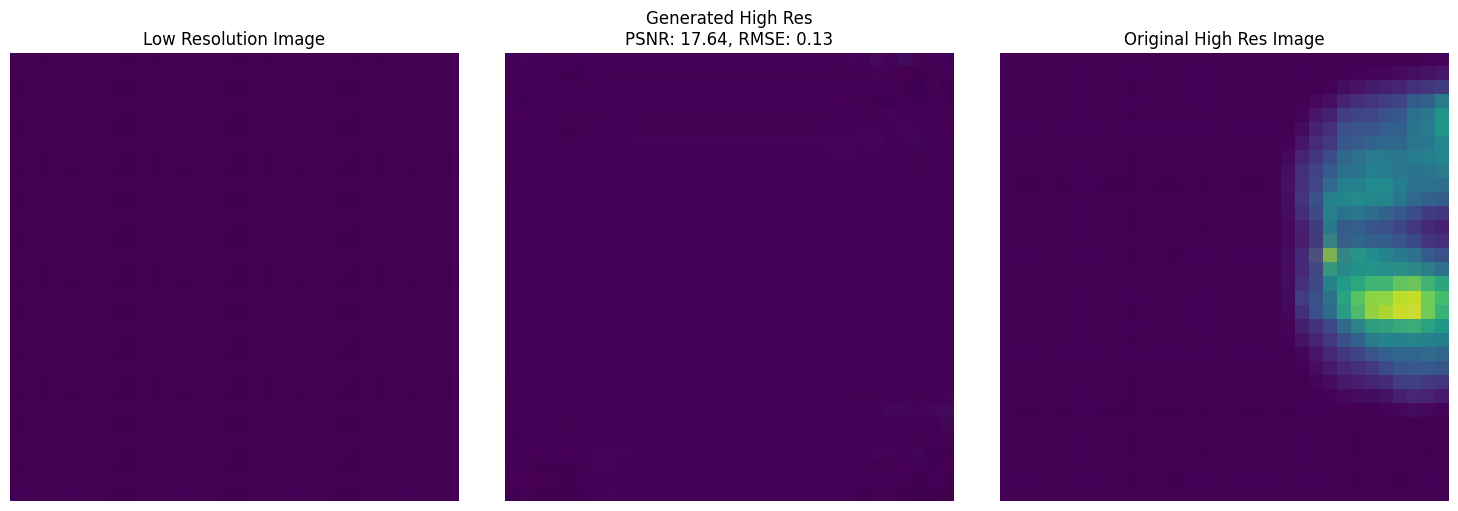

In [6]:
# Function to visualize images
def visualize_images(low_res, generated_high_res, original_high_res, psnr_value, rmse_value):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(low_res.permute(1, 2, 0).numpy())
    axs[0].set_title('Low Resolution Image')
    axs[0].axis('off')

    axs[1].imshow(generated_high_res.permute(1, 2, 0).detach().numpy())
    axs[1].set_title(f'Generated High Res\nPSNR: {psnr_value:.2f}, RMSE: {rmse_value:.2f}')
    axs[1].axis('off')

    axs[2].imshow(original_high_res.permute(1, 2, 0).numpy())
    axs[2].set_title('Original High Res Image')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()

# Function to evaluate and display images
def evaluate_image(index):
    # Ensure index is within bounds
    if index < 0 or index >= len(low_res_images):
        print("Index out of range. Please select a valid index.")
        return

    # Get the images
    low_res = low_res_images[index].unsqueeze(0)  # Add batch dimension
    original_high_res = high_res_images[index]

    # Generate high-resolution image
    generator.eval()  # Set generator to evaluation mode
    with torch.no_grad():
        generated_high_res = generator(low_res).squeeze(0)  # Remove batch dimension

    # Calculate PSNR and RMSE
    psnr_value = psnr(original_high_res.numpy(), generated_high_res.numpy())
    rmse_value = np.sqrt(mse(original_high_res.numpy(), generated_high_res.numpy()))

    # Visualize images and metrics
    visualize_images(low_res.squeeze(0), generated_high_res, original_high_res, psnr_value, rmse_value)

# Example usage
evaluate_image(460)  # Replace 0 with the desired index


In [8]:
import os
import numpy as np
import torch
from PIL import Image

# Function to save the generated high-res images
def save_generated_images(output_folder):
    # Create the folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Loop through all low-res images
    generator.eval()  # Set generator to evaluation mode
    for i, low_res in enumerate(low_res_images):
        # Add batch dimension
        low_res = low_res.unsqueeze(0)

        # Generate high-resolution image
        with torch.no_grad():
            generated_high_res = generator(low_res).squeeze(0)  # Remove batch dimension

        # Convert to NumPy array and scale to 0-255
        generated_image = (generated_high_res.permute(1, 2, 0).detach().numpy() * 255).astype(np.uint8)

        # Convert to PIL image for saving
        pil_image = Image.fromarray(generated_image)

        # Save the image
        image_path = os.path.join(output_folder, f'gen_img_{i+1}.png')
        pil_image.save(image_path)

        print(f"Saved: {image_path}")

# Example usage
output_folder = "generated_7"
save_generated_images(output_folder)


Saved: generated_7/gen_img_1.png
Saved: generated_7/gen_img_2.png
Saved: generated_7/gen_img_3.png
Saved: generated_7/gen_img_4.png
Saved: generated_7/gen_img_5.png
Saved: generated_7/gen_img_6.png
Saved: generated_7/gen_img_7.png
Saved: generated_7/gen_img_8.png
Saved: generated_7/gen_img_9.png
Saved: generated_7/gen_img_10.png
Saved: generated_7/gen_img_11.png
Saved: generated_7/gen_img_12.png
Saved: generated_7/gen_img_13.png
Saved: generated_7/gen_img_14.png
Saved: generated_7/gen_img_15.png
Saved: generated_7/gen_img_16.png
Saved: generated_7/gen_img_17.png
Saved: generated_7/gen_img_18.png
Saved: generated_7/gen_img_19.png
Saved: generated_7/gen_img_20.png
Saved: generated_7/gen_img_21.png
Saved: generated_7/gen_img_22.png
Saved: generated_7/gen_img_23.png
Saved: generated_7/gen_img_24.png
Saved: generated_7/gen_img_25.png
Saved: generated_7/gen_img_26.png
Saved: generated_7/gen_img_27.png
Saved: generated_7/gen_img_28.png
Saved: generated_7/gen_img_29.png
Saved: generated_7/gen_

In [10]:
# THIS CODE WILL GIVE YOU REULSTS OF 50 RANDOM IMAGES FROM THE DATASET
# import random
# import numpy as np
# import torch
# import matplotlib.pyplot as plt

# # Function to visualize images
# def visualize_images_with_metrics(low_res, generated_high_res, original_high_res, psnr_value, rmse_value, image_index):
#     fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#     axs[0].imshow(low_res.permute(1, 2, 0).numpy())
#     axs[0].set_title(f'Low Resolution Image\nIndex: {image_index}')
#     axs[0].axis('off')

#     axs[1].imshow(generated_high_res.permute(1, 2, 0).detach().numpy())
#     axs[1].set_title(f'Generated High Res\nPSNR: {psnr_value:.2f}, RMSE: {rmse_value:.2f}')
#     axs[1].axis('off')

#     axs[2].imshow(original_high_res.permute(1, 2, 0).numpy())
#     axs[2].set_title('Original High Res Image')
#     axs[2].axis('off')

#     plt.tight_layout()
#     plt.show()

# # Function to evaluate and display 50 random images
# def evaluate_random_images_and_visualize(num_images):
#     # Ensure the requested number of images does not exceed the dataset size
#     if num_images > len(low_res_images):
#         print(f"Dataset contains only {len(low_res_images)} images. Adjusting to evaluate all available images.")
#         num_images = len(low_res_images)

#     # Randomly select indices
#     random_indices = random.sample(range(len(low_res_images)), num_images)

#     # Loop through the randomly selected indices
#     generator.eval()  # Set generator to evaluation mode
#     for idx in random_indices:
#         low_res = low_res_images[idx].unsqueeze(0)  # Add batch dimension
#         original_high_res = high_res_images[idx]

#         # Generate high-resolution image
#         with torch.no_grad():
#             generated_high_res = generator(low_res).squeeze(0)  # Remove batch dimension

#         # Calculate PSNR and RMSE
#         psnr_value = psnr(original_high_res.numpy(), generated_high_res.numpy())
#         rmse_value = np.sqrt(mse(original_high_res.numpy(), generated_high_res.numpy()))

#         # Visualize the images and metrics
#         visualize_images_with_metrics(
#             low_res.squeeze(0),
#             generated_high_res,
#             original_high_res,
#             psnr_value,
#             rmse_value,
#             idx
#         )

# # Example usage
# evaluate_random_images_and_visualize(50)  # Evaluate and visualize 50 random images


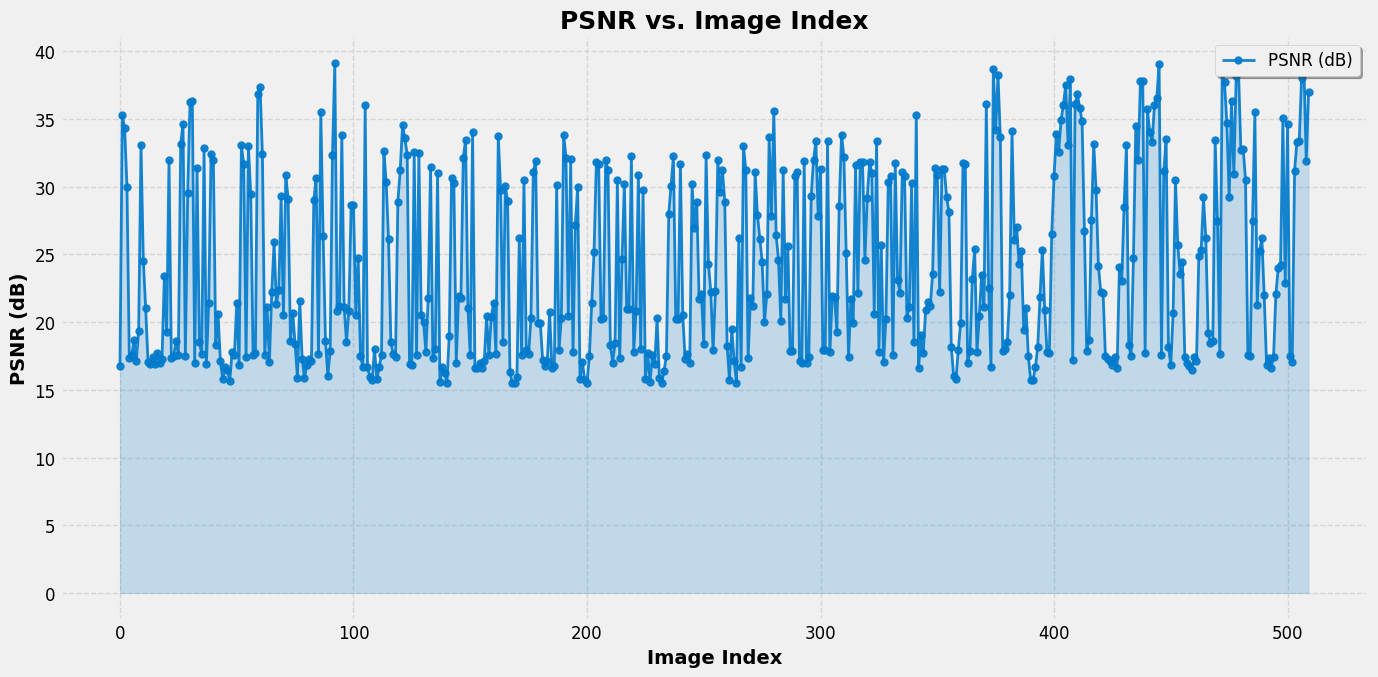

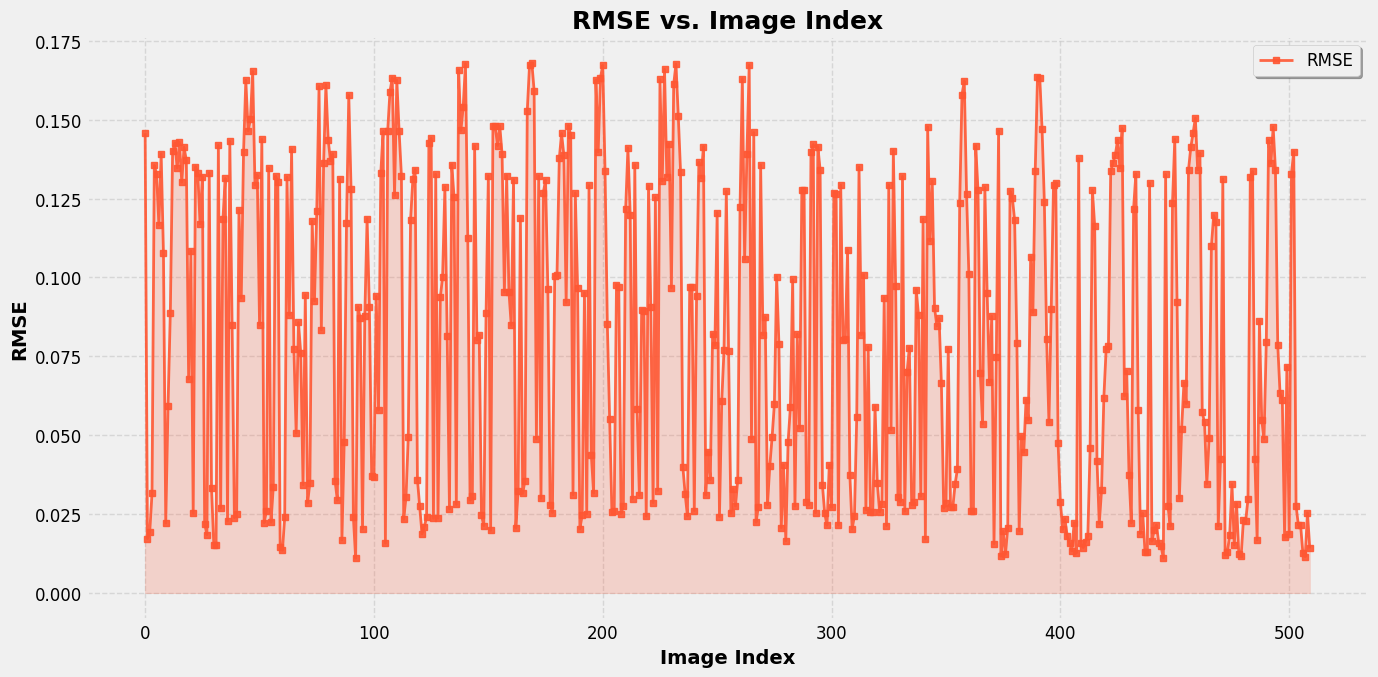

In [8]:
# Function to evaluate PSNR and RMSE for all images
def evaluate_all_images():
    psnr_values = []
    rmse_values = []

    generator.eval()  # Set generator to evaluation mode
    for i in range(len(low_res_images)):
        low_res = low_res_images[i].unsqueeze(0)  # Add batch dimension
        original_high_res = high_res_images[i]

        # Generate high-resolution image
        with torch.no_grad():
            generated_high_res = generator(low_res).squeeze(0)  # Remove batch dimension

        # Calculate PSNR and RMSE
        psnr_value = psnr(original_high_res.numpy(), generated_high_res.numpy())
        rmse_value = np.sqrt(mse(original_high_res.numpy(), generated_high_res.numpy()))

        # Append metrics to the lists
        psnr_values.append(psnr_value)
        rmse_values.append(rmse_value)

    return psnr_values, rmse_values

# Evaluate metrics for all images
psnr_values_all, rmse_values_all = evaluate_all_images()

import matplotlib.pyplot as plt

# Function to plot PSNR and RMSE with enhanced inbuilt style
def plot_metrics_with_enhanced_style(psnr_values, rmse_values):
    # Use a professional built-in style
    plt.style.use('fivethirtyeight')  # A clean, visually pleasing style

    indices = range(len(psnr_values))  # Image indices

    # Plot PSNR values
    plt.figure(figsize=(14, 7))
    plt.plot(
        indices, psnr_values, label='PSNR (dB)', color='#007acc',
        marker='o', markersize=5, linewidth=2, alpha=0.9
    )
    plt.fill_between(indices, psnr_values, color='#007acc', alpha=0.2)  # Add shading for emphasis
    plt.xlabel('Image Index', fontsize=14, fontweight='bold')
    plt.ylabel('PSNR (dB)', fontsize=14, fontweight='bold')
    plt.title('PSNR vs. Image Index', fontsize=18, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True)
    plt.tight_layout()
    plt.show()

    # Plot RMSE values
    plt.figure(figsize=(14, 7))
    plt.plot(
        indices, rmse_values, label='RMSE', color='#ff5733',
        marker='s', markersize=5, linewidth=2, alpha=0.9
    )
    plt.fill_between(indices, rmse_values, color='#ff5733', alpha=0.2)  # Add shading for emphasis
    plt.xlabel('Image Index', fontsize=14, fontweight='bold')
    plt.ylabel('RMSE', fontsize=14, fontweight='bold')
    plt.title('RMSE vs. Image Index', fontsize=18, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12, loc='upper right', frameon=True, shadow=True)
    plt.tight_layout()
    plt.show()

# Example usage
plot_metrics_with_enhanced_style(psnr_values_all, rmse_values_all)
